# Time series forecasting using ARIMA
### Import necessary libraries

In [1]:
%matplotlib notebook

import numpy
import pandas
import datetime
import sys
import time
import psycopg2
import matplotlib.pyplot as ma
import statsmodels.tsa.seasonal as st
import statsmodels.tsa.arima_model as arima
import statsmodels.tsa.stattools as tools

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Load necessary CSV file

In [2]:
try: 
    ts = pandas.read_csv('../../datasets/srv-2-tc-5m.csv')
except:
    print("I am unable to connect to read .csv file", sep=',', header=1)

ts.index = pandas.to_datetime(ts['ts'])

# delete unnecessary columns
del ts['id']
del ts['ts']
del ts['l1']
del ts['l2']
del ts['l3']
del ts['l4']
del ts['apmi']

# print table info
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8829 entries, 2018-06-15 10:40:00 to 2018-07-16 13:40:00
Data columns (total 1 columns):
cnt    8829 non-null int64
dtypes: int64(1)
memory usage: 138.0 KB


### Get values from specified range

In [3]:
ts = ts['2018-06-16':'2018-07-15']

### Remove possible zero and NA values (by interpolation)
We are using MAPE formula for counting the final score, so there cannot occure any zero values in the time series. Replace them with NA values. NA values are later explicitely removed by linear interpolation.

In [4]:
def print_values_stats():
    print("Zero Values:\n",sum([(1 if x == 0 else 0) for x in ts.values]),"\n\nMissing Values:\n",ts.isnull().sum(),"\n\nFilled in Values:\n",ts.notnull().sum(), "\n")

idx = pandas.date_range(ts.index.min(), ts.index.max(), freq="5min")
ts = ts.reindex(idx, fill_value=None)
print("Before interpolation:\n")
print_values_stats()
ts = ts.replace(0, numpy.nan)
ts = ts.interpolate(limit_direction="both")
print("After interpolation:\n")
print_values_stats()

Before interpolation:

Zero Values:
 0 

Missing Values:
 cnt    99
dtype: int64 

Filled in Values:
 cnt    8541
dtype: int64 

After interpolation:

Zero Values:
 0 

Missing Values:
 cnt    0
dtype: int64 

Filled in Values:
 cnt    8640
dtype: int64 



### Plot values

<IPython.core.display.Javascript object>


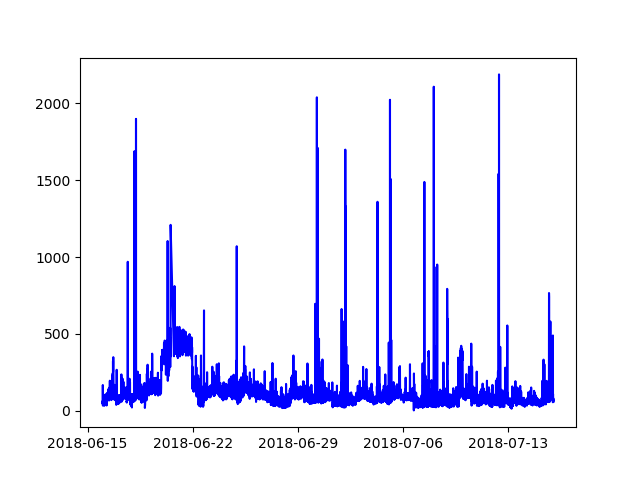

/usr/lib/python3/dist-packages/matplotlib/backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


In [5]:
# Idea: Plot figure now and do not wait on ma.show() at the end of the notebook
ma.ion()
ma.show()
fig1 = ma.figure(1)
ma.plot(ts, color="blue")
ma.draw()
try:
    ma.pause(0.001) # throws NotImplementedError, ignore it
except:
    pass

### Ignore timestamps, make the time series single dimensional
Since now the time series is represented by continuous single-dimensional Python list. ARIMA does not need timestamps or any irrelevant data.

In [6]:
dates = ts.index #  save dates for further use
ts = [x[0] for x in ts.values]

### Split time series into train and test series
We have decided to split train and test time series by two weeks.

In [7]:
train_data_length = 12*24*7
ts_train = ts[:train_data_length]
ts_test = ts[train_data_length+1:]

### Estimate integrated (I) parameter
Check time series stationarity and estimate it's integrated parameter (maximum integration value is 2). The series itself is highly seasonal, so we can assume that the time series is not stationary.

In [8]:
def check_stationarity(ts, critic_value = 0.05):
    try:
        result = tools.adfuller(ts)
        return result[0] < 0.0 and result[1] < critic_value
    except:
        # Program may raise an exception when there are NA values in TS 
        return False

integrate_param = 0
ts_copy = pandas.Series(ts_train, copy=True) # Create copy for stationarizing

while not check_stationarity(ts_copy) and integrate_param < 2:
    integrate_param += 1
    ts_copy = ts_copy - ts_copy.shift()
    ts_copy.dropna(inplace=True) # Remove initial NA values
    
print("Estimated integrated (I) parameter: ", integrate_param, "\n")

Estimated integrated (I) parameter:  0 



### Print ACF and PACF graphs for AR(p) and MA(q) order estimation
AutoCorellation and Parcial AutoCorellation Functions are necessary for ARMA order estimation. Configure the *NLagsACF* and *NlagsPACF* variables for number of lagged values in ACF and PACF graphs.

<IPython.core.display.Javascript object>


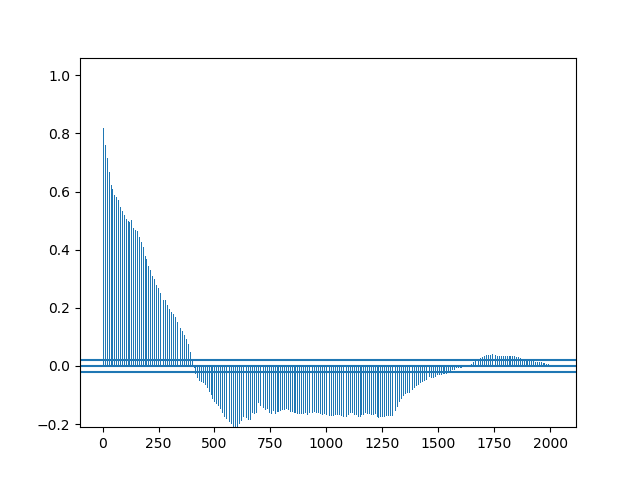

/usr/lib/python3/dist-packages/matplotlib/backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


<IPython.core.display.Javascript object>


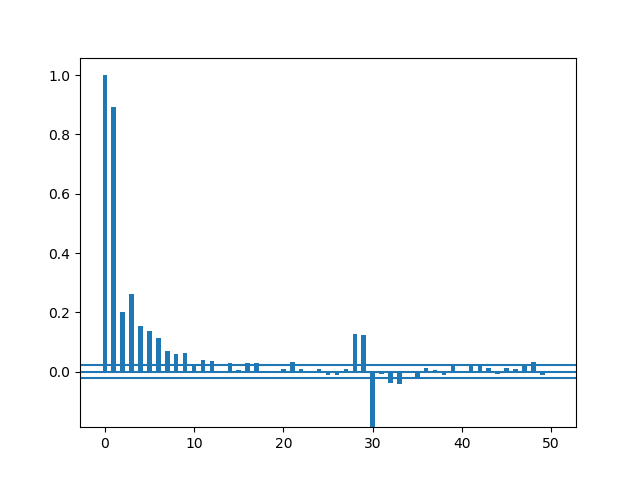

/usr/lib/python3/dist-packages/matplotlib/backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


In [9]:
def plot_bar(ts, horizontal_line=None):
    ma.bar(range(0, len(ts)), ts, width=0.5)
    ma.axhline(0)
    if horizontal_line != None:
        ma.axhline(horizontal_line, linestyle="-")
        ma.axhline(-horizontal_line, linestyle="-")

    ma.draw()
    try:
        ma.pause(0.001) # throws NotImplementedError, ignore it
    except:
        pass


NlagsACF = train_data_length
NLagsPACF = 50
# ACF
ma.figure(2)
plot_bar(tools.acf(ts_train, nlags=NlagsACF), 1.96 / numpy.sqrt(len(ts)))
# PACF
ma.figure(3)
plot_bar(tools.pacf(ts_train, nlags=NLagsPACF), 1.96 / numpy.sqrt(len(ts)))

### ARIMA order estimation
According to the Box-Jenkins model (https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc446.htm) we assumed that this time series should be an AR(p) model. The ACF graphs is positive and negative altering around the main axis, the PACF graph has many significant spikes. We can calmly ignore spikes around 30th index. I believe that anything larger than AR(4) model would be unnecessary and very time consuming for this time series. I would choose ARIMA(2,0,0) or ARIMA(4,0,0), but its better to compare them using AIC criterion (https://www.thoughtco.com/introduction-to-akaikes-information-criterion-1145956).

In [10]:
ARIMA_order = None
best_score = sys.maxsize
    
for order in [(2,0,0), (4,0,0)]:
    model_fit = arima.ARIMA(ts_train, order=order).fit(disp=0)
    score = model_fit.aic
    if score <= best_score:
        best_score = score
        ARIMA_order = order

print("Selected ARIMA order: ", ARIMA_order)

/home/stepan/.local/lib/python3.6/site-packages/scipy/signal/signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/stepan/.local/lib/python3.6/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/stepan/.local/lib/python3.6/site-packages/scipy/signal/signaltools.py:1342: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpr

Selected ARIMA order:  (4, 0, 0)


### Prediction configurations
You can specify how many values you want to use for ARIMA model fitting (by setting *N_train_data* variable) and how many new values you want to predict in single step (by setting *N_values_to_forecast* variable).

In [11]:
M_train_data = sys.maxsize
N_values_to_forecast = 1

### Forecast new values
Unexpectedly, we have a very large time series (over 8 thousand samples), so the forecasting takes much time.

In [12]:
predictions = []
confidence = []

print("Forecasting started...")
start_time = time.time()
ts_len = len(ts)

for i in range(train_data_length+1, ts_len, N_values_to_forecast):
    try:
        start = i-M_train_data if i-M_train_data >= 0 else 0
        arima_model = arima.ARIMA(ts[start:i], order=ARIMA_order).fit(disp=0)
        forecast = arima_model.forecast(steps=N_values_to_forecast)
        for j in range(0, N_values_to_forecast):
            predictions.append(forecast[0][j])
            confidence.append(forecast[2][j])
    except:
        print("Error during forecast: ", i, i+N_values_to_forecast)
        # Push back last successful predictions
        for j in range(0, N_values_to_forecast):
            predictions.append(predictions[-1] if len(predictions) > 0 else 0)
            confidence.append(confidence[-1] if len(confidence) > 0 else 0)

print("Forecasting finished")
print("Time elapsed: ", time.time() - start_time)

Forecasting started...


/home/stepan/.local/lib/python3.6/site-packages/scipy/signal/signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/stepan/.local/lib/python3.6/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/stepan/.local/lib/python3.6/site-packages/scipy/signal/signaltools.py:1342: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpr

Forecasting finished
Time elapsed:  2436.8254227638245


### Count mean absolute percentage error
We use MAPE (https://www.forecastpro.com/Trends/forecasting101August2011.html) instead of MSE because the result of MAPE does not depend on size of values.

In [13]:
values_sum = 0
for value in zip(ts_test, predictions):
    actual = value[0]
    predicted = value[1]
    values_sum += abs((actual - predicted) / actual)

values_sum *= 100/len(predictions)
print("MAPE: ", values_sum, "%\n")

MAPE:  36.236242062584346 %



MAPE statistics failed, because there are zero values in the time series.

### Plot forecasted values

<IPython.core.display.Javascript object>


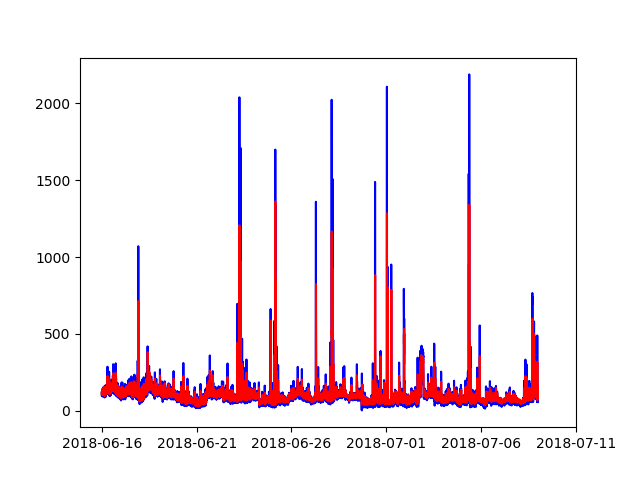

In [14]:
fig2 = ma.figure(4)
ma.plot(ts_test, color="blue")
ma.plot(predictions, color="red")
ts_len = len(ts)
date_offset_indices = ts_len // 6
num_date_ticks = ts_len // date_offset_indices + 1
ma.xticks(range(0, ts_len, date_offset_indices), [x.date().strftime('%Y-%m-%d') for x in dates[::date_offset_indices]])
ma.draw()